In [1]:
!pip install opencv-python tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
from PIL import Image
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score



In [4]:
fracture_dir= '/content/drive/MyDrive/fracturel2/archive (6)/train/fractured'
non_fracture_dir = '/content/drive/MyDrive/fracturel2/archive (6)/train/not_fractured'


In [5]:
fracture_img = [f for f in os.listdir(fracture_dir) if os.path.isfile(os.path.join(fracture_dir, f))]

fracture_img[:10]

['75-rotated1-rotated3-rotated3.jpg',
 '75-rotated1-rotated2-rotated1.jpg',
 '75-rotated1-rotated1-rotated1.jpg',
 '74-rotated3-rotated3.jpg',
 '75-rotated1-rotated2-rotated3.jpg',
 '74.jpg',
 '75-rotated1-rotated1-rotated2.jpg',
 '75-rotated1-rotated1-rotated3.jpg',
 '75-rotated1-rotated2.jpg',
 '75-rotated1-rotated2-rotated2.jpg']

In [6]:
print(len(fracture_img))

4480


In [7]:
non_fracture_img = [f for f in os.listdir(non_fracture_dir) if os.path.isfile(os.path.join(non_fracture_dir, f))]

non_fracture_img[:10]

['6-rotated1-rotated1-rotated1.jpg',
 '6-rotated1-rotated1-rotated1-rotated1.jpg',
 '6-rotated1-rotated1.jpg',
 '6-rotated1-rotated1-rotated2.jpg',
 '6-rotated1-rotated2-rotated1-rotated1.jpg',
 '6-rotated1-rotated1-rotated2-rotated1.jpg',
 '6-rotated1-rotated1-rotated3.jpg',
 '6-rotated1-rotated1-rotated3-rotated1.jpg',
 '59.jpg',
 '59-rotated3-rotated3.jpg']

In [8]:
print(len(non_fracture_img))

4383


In [9]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        if label == 1:
            image_path = os.path.join(fracture_dir, img)
        else:
            image_path = os.path.join(non_fracture_dir, img)

        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [10]:
dataset = create_dataset(fracture_img,1)

100%|██████████| 4480/4480 [01:28<00:00, 50.46it/s] 


In [11]:
len(dataset)

4480

In [12]:
dataset = create_dataset(non_fracture_img,0)

100%|██████████| 4383/4383 [00:28<00:00, 154.71it/s]


In [13]:
len(dataset)

8863

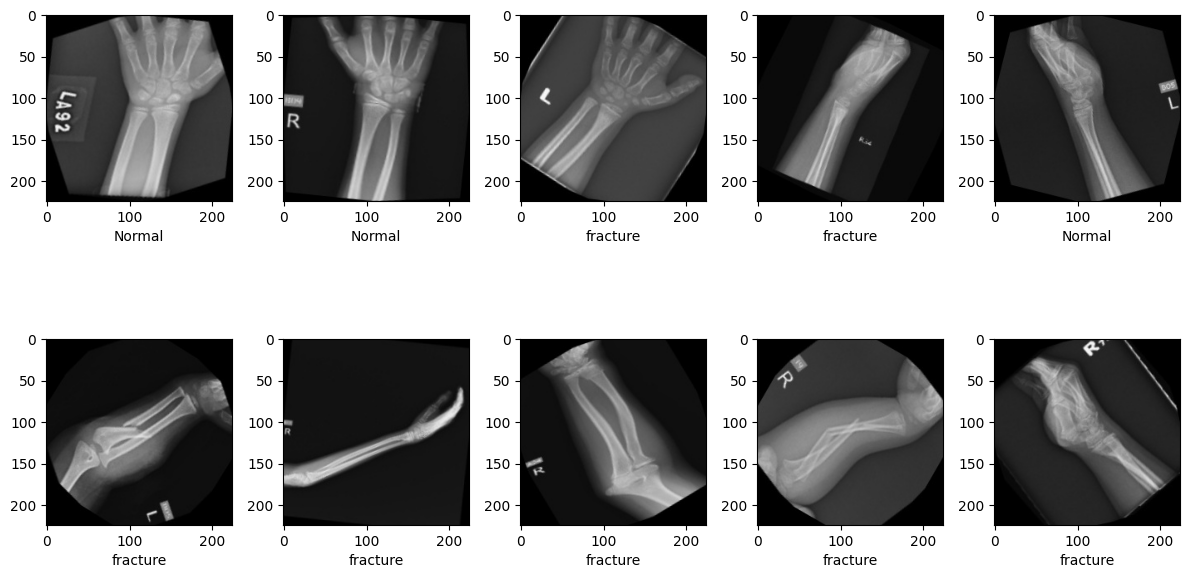

In [14]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "fracture"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [15]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [16]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
for layer in vgg.layers:
    layer.trainable = False

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg19.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1)

In [21]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, earlystop]
)

Epoch 1/10
222/221 [==============================] - ETA: 0s - loss: 1.9959 - accuracy: 0.6429
Epoch 1: val_accuracy improved from -inf to 0.82177, saving model to vgg19.keras
221/221 [==============================] - 135s 555ms/step - loss: 1.9959 - accuracy: 0.6429 - val_loss: 0.4043 - val_accuracy: 0.8218
Epoch 2/10
222/221 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7283
Epoch 2: val_accuracy improved from 0.82177 to 0.86971, saving model to vgg19.keras
221/221 [==============================] - 108s 489ms/step - loss: 0.5204 - accuracy: 0.7283 - val_loss: 0.3110 - val_accuracy: 0.8697
Epoch 3/10
222/221 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.7653
Epoch 3: val_accuracy improved from 0.86971 to 0.89791, saving model to vgg19.keras
221/221 [==============================] - 106s 479ms/step - loss: 0.4599 - accuracy: 0.7653 - val_loss: 0.2463 - val_accuracy: 0.8979
Epoch 4/10
222/221 [==============================] - ETA:

In [22]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

56/56 [==============================] - 8s 149ms/step - loss: 0.1288 - accuracy: 0.9526
loss: 0.12881498038768768
Accuracy: 0.952622652053833


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test,y_pred))

56/56 [==============================] - 9s 151ms/step
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       847
           1       0.93      0.98      0.96       926

    accuracy                           0.95      1773
   macro avg       0.95      0.95      0.95      1773
weighted avg       0.95      0.95      0.95      1773



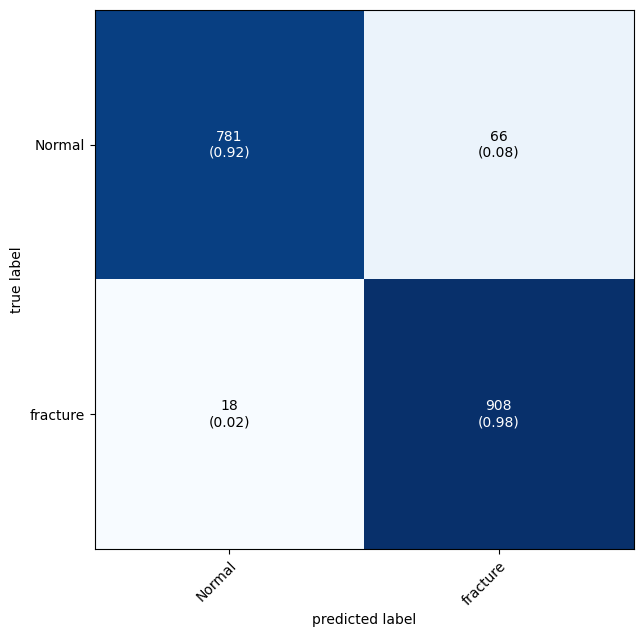

In [24]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","fracture"],
                      show_normed = True);

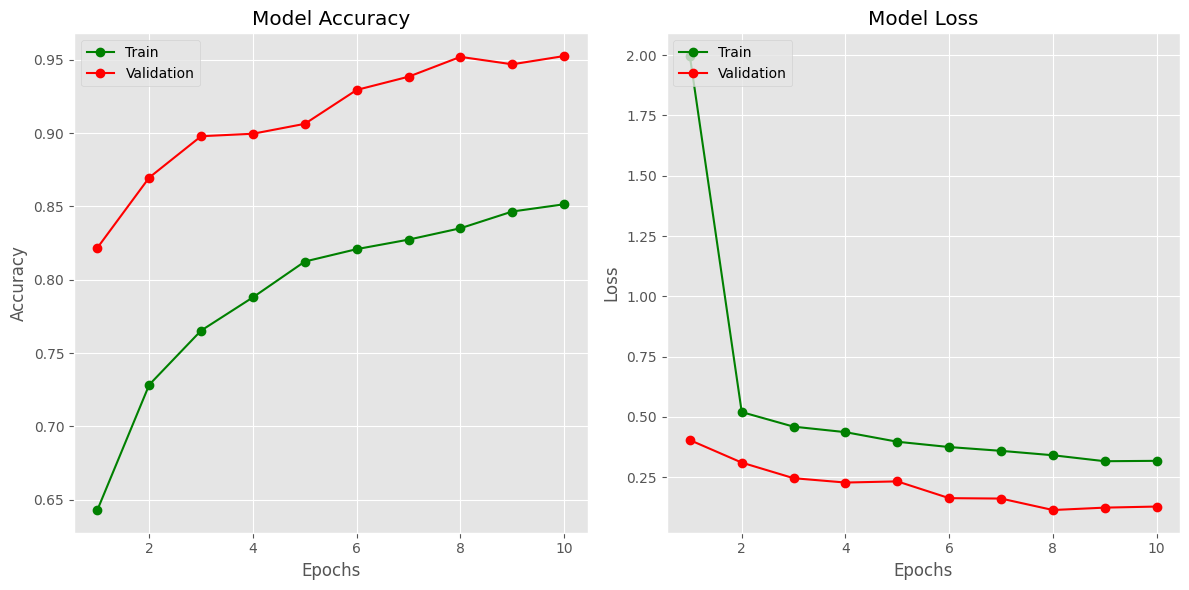

In [25]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-", label="Train")
plt.plot(epochs, history.history["val_accuracy"], "ro-", label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-", label="Train")
plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


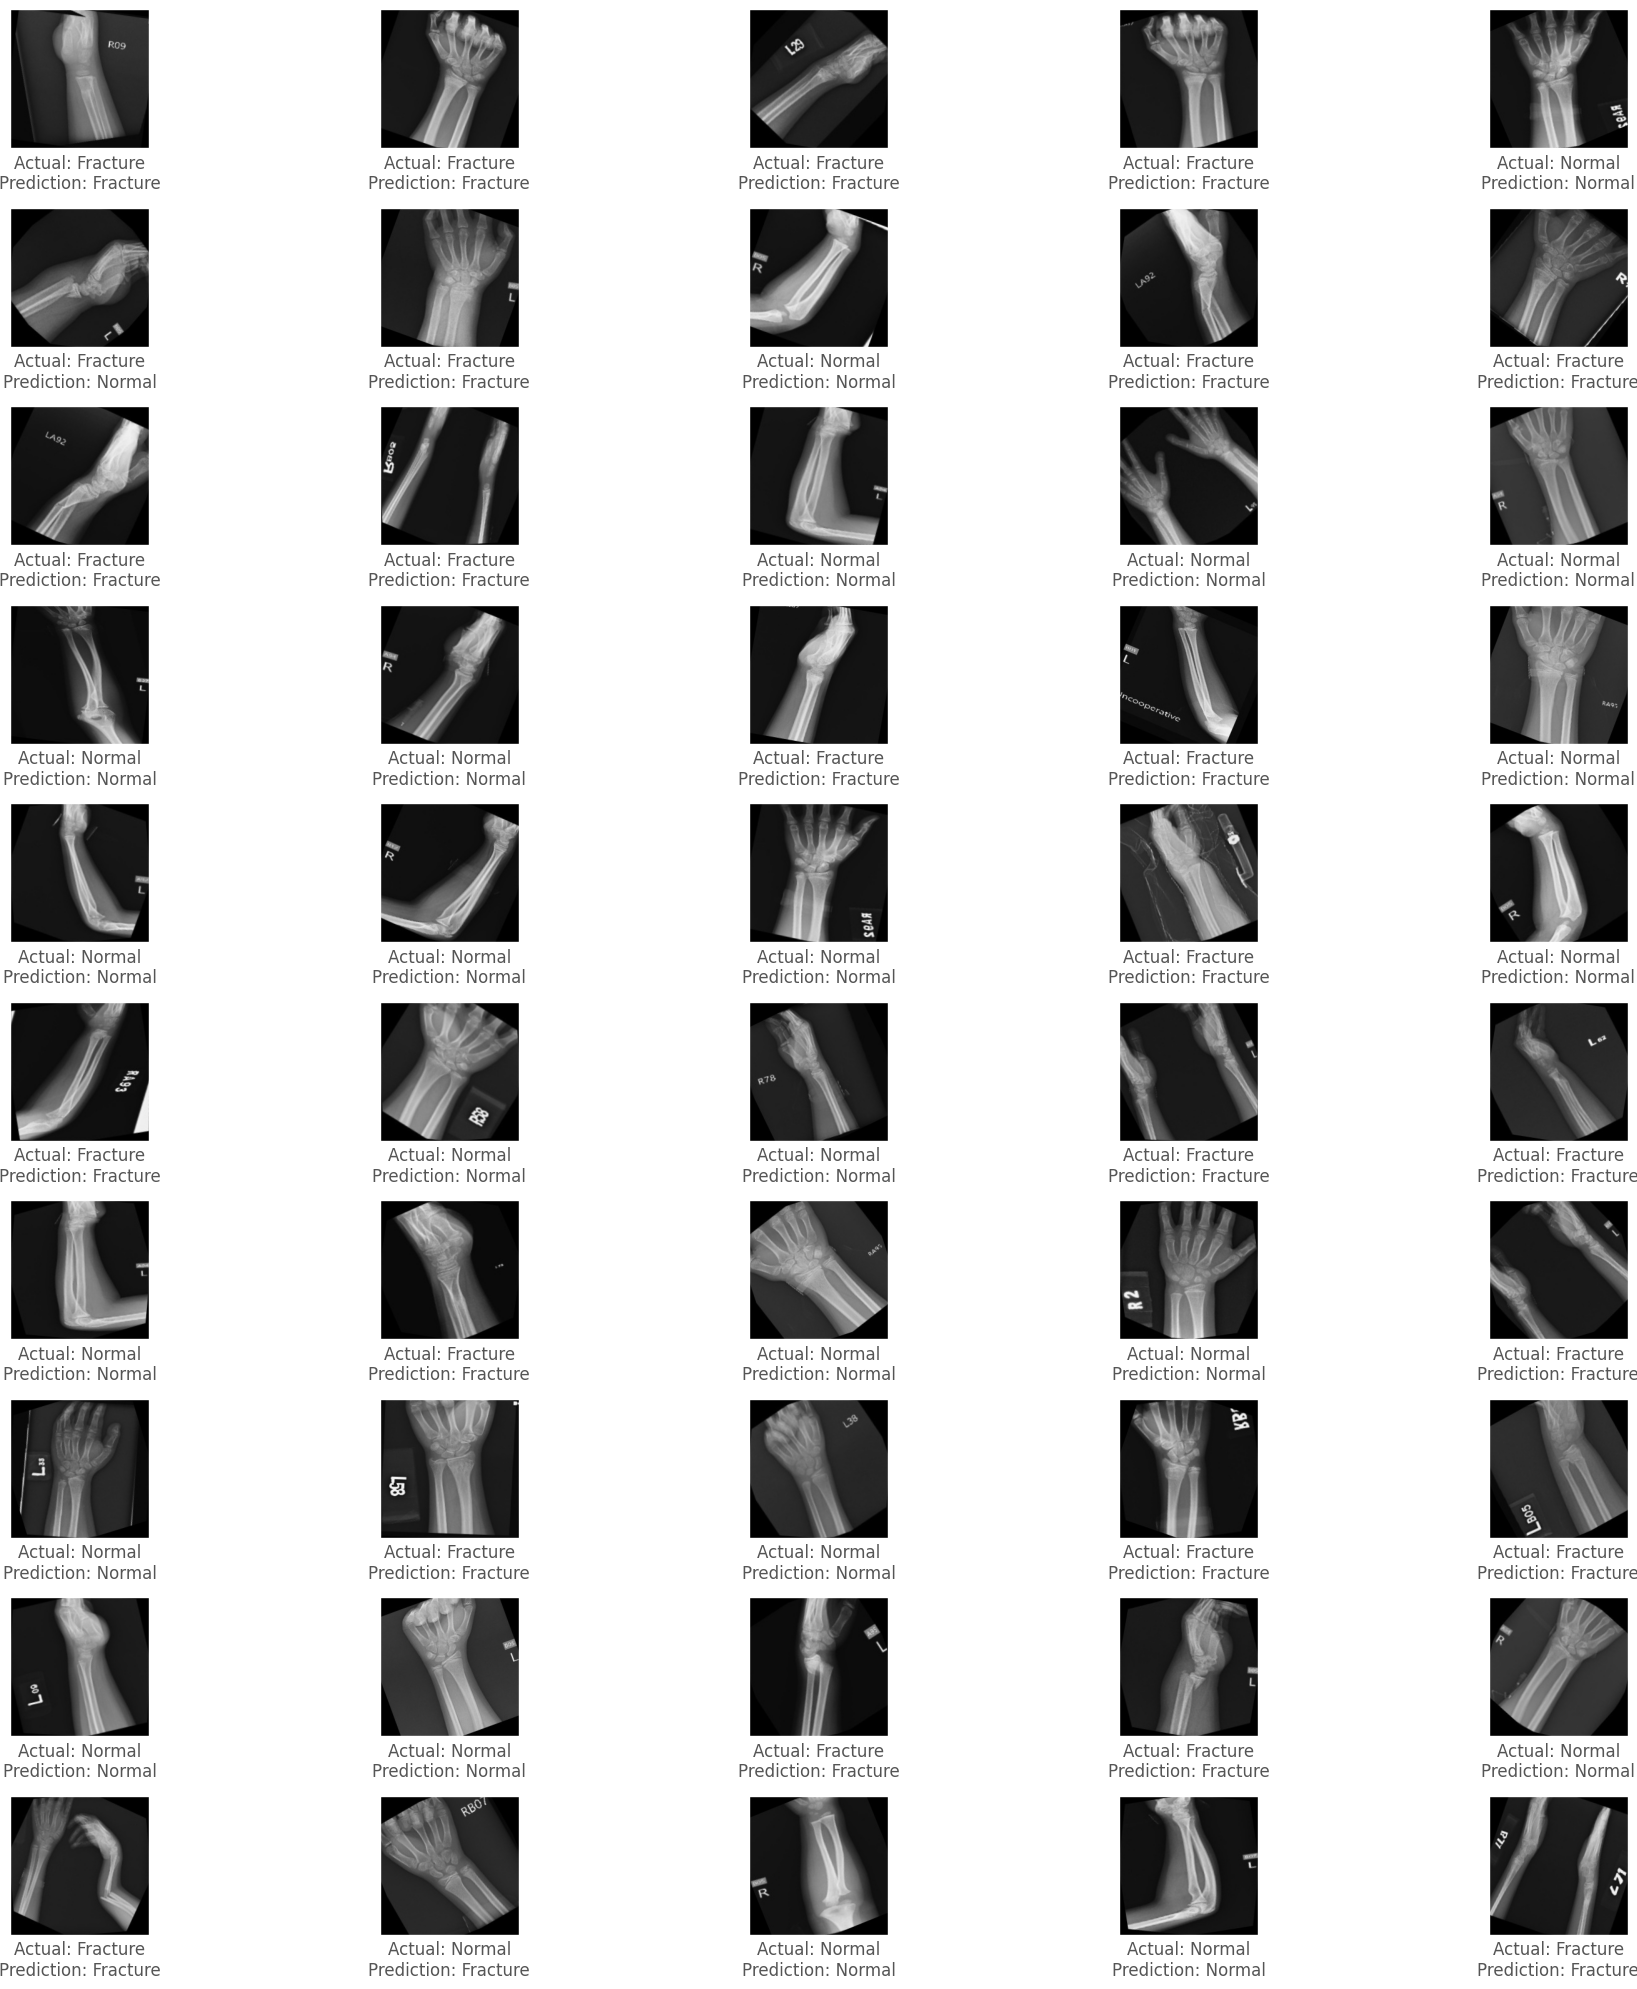

In [32]:
plt.figure(figsize=(20,20))

# Plotting 50 images
for i in range(50):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category == 0:
        label = "Normal"
    else:
        label = "Fracture"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Fracture"

    plt.subplot(10, 5, i+1)
    plt.imshow(image)
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()